In [1]:
## load packages
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
## load data
chap_4_file = "./data/pbp_py_chap_4.csv"
if os.path.isfile(chap_4_file):
    pbp_py = pd.read_csv(chap_4_file, low_memory=False)
else:
    seasons = range(2016, 2022 + 1)
    pbp_py = nfl.import_pbp_data(seasons)
    pbp_py.to_csv(chap_4_file)

In [3]:
pbp_py_run = pbp_py.query(
    'play_type == "run" & rusher_id.notnull() &'
    + "down.notnull() & run_location.notnull()"
).reset_index()

In [4]:
pbp_py_run.loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] = 0

In [5]:
## set theme
sns.set_theme(style="whitegrid", palette="colorblind")

In [6]:
# Change down to be an integer
pbp_py_run.down = pbp_py_run.down.astype(str)

/Users/nick/anaconda3/envs/football_book_code/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nick/anaconda3/envs/football_book_code/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nick/anaconda3/envs/football_book_code/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nick/anaconda3/envs/football_book_code/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

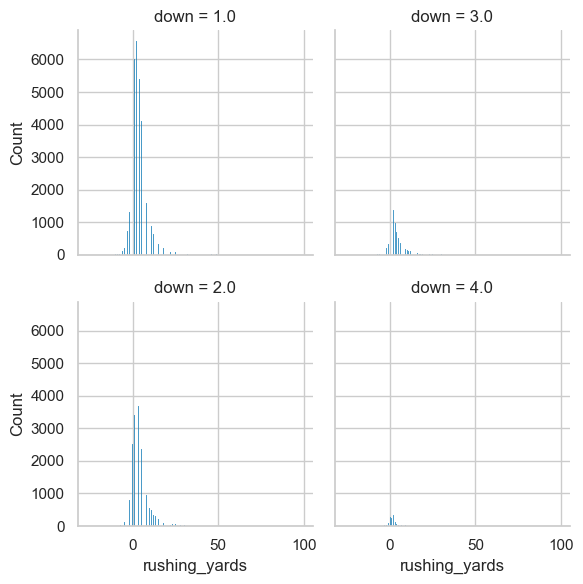

In [7]:
# Plot rushing yards by down
g = sns.FacetGrid(data=pbp_py_run, col="down", col_wrap=2)
g.map_dataframe(sns.histplot, x="rushing_yards")
plt.show()

In [8]:
plt.figure(figsize=(6, 4.25), dpi=600)
g = sns.FacetGrid(data=pbp_py_run, col="down", col_wrap=2)
g.map_dataframe(sns.histplot, x="rushing_yards")
plt.savefig("fig_4_1.png", dpi=600)
plt.close()

/Users/nick/anaconda3/envs/football_book_code/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nick/anaconda3/envs/football_book_code/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nick/anaconda3/envs/football_book_code/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nick/anaconda3/envs/football_book_code/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

<Figure size 3600x2550 with 0 Axes>

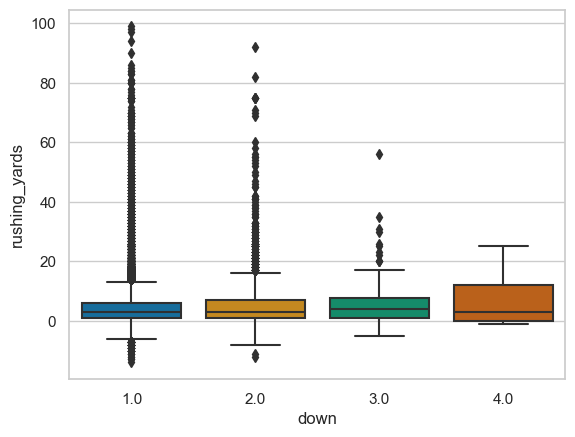

In [9]:
## Look at only plays with 10 yards to go
sns.boxplot(data=pbp_py_run.query("ydstogo == 10"), x="down", y="rushing_yards")
plt.show()

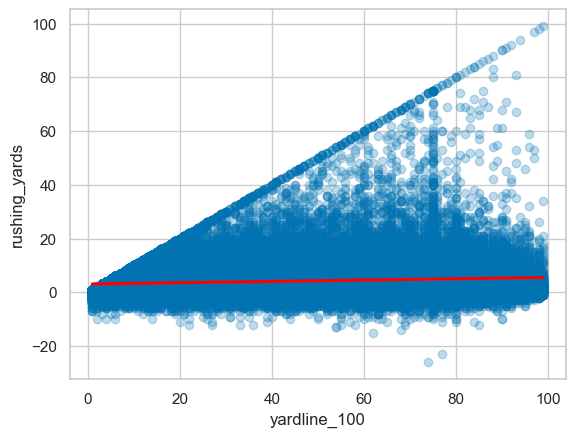

In [10]:
## scatterplot for trendline
sns.regplot(
    data=pbp_py_run,
    x="yardline_100",
    y="rushing_yards",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
)
plt.show()

In [11]:
## Bin and plot
pbp_py_run_y100 = pbp_py_run.groupby("yardline_100").agg({"rushing_yards": ["mean"]})
pbp_py_run_y100.columns = list(map("_".join, pbp_py_run_y100.columns))
pbp_py_run_y100.reset_index(inplace=True)

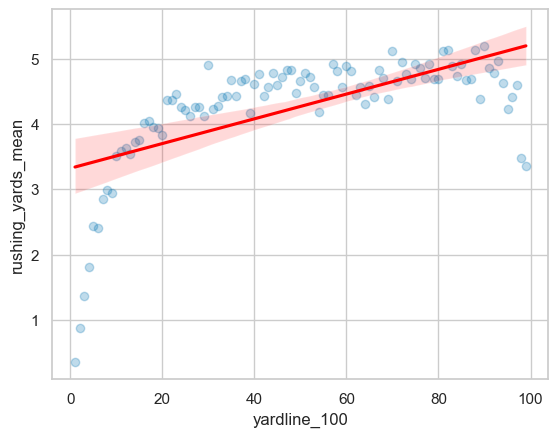

In [12]:
sns.regplot(
    data=pbp_py_run_y100,
    x="yardline_100",
    y="rushing_yards_mean",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
)
plt.show()

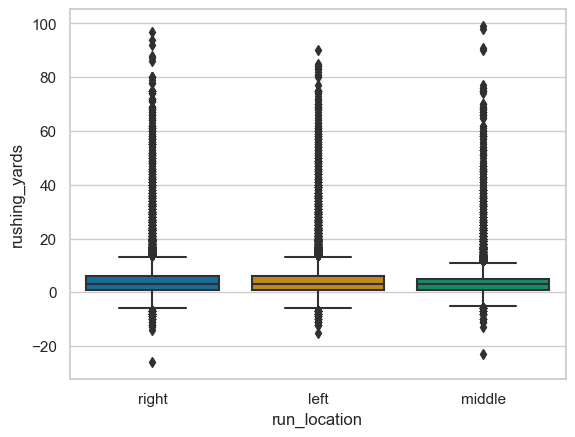

In [13]:
## Boxplot by run location
sns.boxplot(data=pbp_py_run, x="run_location", y="rushing_yards")
plt.show()

In [14]:
## Score differential
pbp_py_run_sd = pbp_py_run.groupby("score_differential").agg(
    {"rushing_yards": ["mean"]}
)
pbp_py_run_sd.columns = list(map("_".join, pbp_py_run_sd.columns))
pbp_py_run_sd.reset_index(inplace=True)

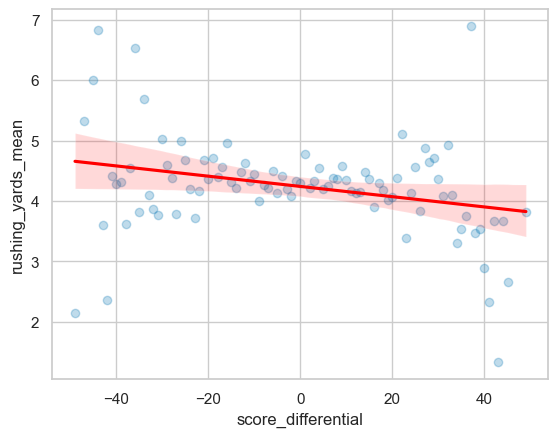

In [15]:
## plot score differential
sns.regplot(
    data=pbp_py_run_sd,
    x="score_differential",
    y="rushing_yards_mean",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
)
plt.show()

In [16]:
## Multiple regression Python
pbp_py_run.down = pbp_py_run.down.astype(str)
expected_yards_py = smf.ols(
    data=pbp_py_run,
    formula="rushing_yards ~ 1 + down + ydstogo + "
    + "down:ydstogo + yardline_100 + "
    + "run_location + score_differential",
).fit()
pbp_py_run["ryoe"] = expected_yards_py.resid

In [17]:
## Look at model outputs
print(expected_yards_py.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     136.6
Date:                Sun, 21 Jan 2024   Prob (F-statistic):          3.43e-313
Time:                        23:27:14   Log-Likelihood:            -2.9764e+05
No. Observations:               91442   AIC:                         5.953e+05
Df Residuals:                   91430   BIC:                         5.954e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

In [18]:
## Analyze RYOE
ryoe_py = pbp_py_run.groupby(["season", "rusher_id", "rusher"]).agg(
    {"ryoe": ["count", "sum", "mean"], "rushing_yards": ["mean"]}
)
ryoe_py.columns = list(map("_".join, ryoe_py.columns))
ryoe_py.reset_index(inplace=True)
ryoe_py = ryoe_py.rename(
    columns={
        "ryoe_count": "n",
        "ryoe_sum": "ryoe_total",
        "ryoe_mean": "ryoe_per",
        "rushing_yards_mean": "yards_per_carry",
    }
).query("n > 50")
print(ryoe_py.sort_values("ryoe_total", ascending=False))

      season   rusher_id      rusher    n  ryoe_total  ryoe_per  \
1870    2021  00-0036223    J.Taylor  332  471.232840  1.419376   
1350    2020  00-0032764     D.Henry  395  345.948778  0.875820   
1183    2019  00-0034796   L.Jackson  126  328.524757  2.607339   
1069    2019  00-0032764     D.Henry  386  311.641243  0.807361   
1383    2020  00-0033293     A.Jones  221  301.778866  1.365515   
...      ...         ...         ...  ...         ...       ...   
627     2018  00-0027029     L.McCoy  161 -208.392834 -1.294365   
51      2016  00-0027155  R.Jennings  186 -228.084591 -1.226261   
629     2018  00-0027325    L.Blount  154 -235.865233 -1.531592   
991     2019  00-0030496      L.Bell  245 -338.432836 -1.381359   
246     2016  00-0032241    T.Gurley  278 -344.314622 -1.238542   

      yards_per_carry  
1870         5.454819  
1350         5.232911  
1183         6.880952  
1069         5.145078  
1383         5.565611  
...               ...  
627          3.192547  
51 

In [19]:
## sort by RYOE per carry
print(ryoe_py.sort_values("ryoe_per", ascending=False))

      season   rusher_id        rusher    n  ryoe_total  ryoe_per  \
2103    2022  00-0034796     L.Jackson   72  280.752317  3.899338   
1183    2019  00-0034796     L.Jackson  126  328.524757  2.607339   
1210    2019  00-0035228      K.Murray   53  137.636412  2.596913   
2239    2022  00-0036945      J.Fields   77  177.409631  2.304021   
1467    2020  00-0034796     L.Jackson  118  258.059489  2.186945   
...      ...         ...           ...  ...         ...       ...   
1901    2021  00-0036414       C.Akers   72 -129.834294 -1.803254   
533     2017  00-0032940  D.Washington   57 -105.377929 -1.848736   
1858    2021  00-0035860       T.Jones   54 -100.987077 -1.870131   
60      2016  00-0027791      J.Starks   63 -129.298259 -2.052353   
1184    2019  00-0034799     K.Ballage   74 -191.983153 -2.594367   

      yards_per_carry  
2103         7.930556  
1183         6.880952  
1210         6.867925  
2239         6.506494  
1467         6.415254  
...               ...  
190

In [20]:
## RYOE stability
#  keep only the columns needed
cols_keep = ["season", "rusher_id", "rusher", "ryoe_per", "yards_per_carry"]

In [21]:
# create current dataframe
ryoe_now_py = ryoe_py[cols_keep].copy()

In [22]:
# create last-year's dataframe
ryoe_last_py = ryoe_py[cols_keep].copy()

In [23]:
# rename columns
ryoe_last_py.rename(
    columns={"ryoe_per": "ryoe_per_last", "yards_per_carry": "yards_per_carry_last"},
    inplace=True,
)

In [24]:
# add 1 to season
ryoe_last_py["season"] += 1

In [25]:
# merge together
ryoe_lag_py = ryoe_now_py.merge(
    ryoe_last_py, how="inner", on=["rusher_id", "rusher", "season"]
)

In [26]:
## Stability for yards per carry
ryoe_lag_py[["yards_per_carry_last", "yards_per_carry"]].corr()

,yards_per_carry_last,yards_per_carry
yards_per_carry_last,1.000000,0.347267
yards_per_carry,0.347267,1.000000


In [27]:
## Stability for RYOE
ryoe_lag_py[["ryoe_per_last", "ryoe_per"]].corr()

,ryoe_per_last,ryoe_per
ryoe_per_last,1.000000,0.373582
ryoe_per,0.373582,1.000000
